
# <span style="color:green">__Machine Learning for the Kickstarter Challenge__
----



## <span style="color:navy">__Set-up and Import__

In [41]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timezone
import json

# Libraries for data import
import os
import glob

# Preprocessing
#from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer


# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')

We will import the data from the database using sqlalchemy. After we imported the data we can directly save it as a .csv file so we don't have to run the query every time we want to execute the notebook.

In [42]:
df = pd.read_csv('data/df_cleaned_for_ML.csv')

In [43]:
df.head()

,backers_count,category,country,created_at,deadline,id,is_starrable,launched_at,staff_pick,state,...,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,percent_pledged
0,47,games,US,2017-08-02 16:28:13,2017-09-09 19:00:59,928751314,False,2017-08-10 19:00:59,False,successful,...,8,1,10,9,0,0,19,19,41.49,195.00
1,271,music,US,2012-09-30 08:45:33,2013-06-12 07:03:15,928014092,False,2013-05-13 07:03:15,False,successful,...,17,1,13,12,3,3,7,7,82.67,149.36
2,3,games,GB,2017-01-07 10:11:11,2017-03-13 18:22:56,596091328,False,2017-01-12 19:22:56,False,failed,...,5,1,12,13,22,22,19,18,55.13,1.36
3,3,publishing,US,2012-12-06 19:04:31,2013-01-09 21:32:07,998516049,False,2012-12-10 21:32:07,False,successful,...,4,1,10,9,32,32,21,21,940.00,100.71
4,35,music,US,2014-10-24 19:35:50,2015-05-02 04:25:46,1224600291,False,2015-04-02 04:25:46,False,successful,...,22,0,2,2,25,25,4,4,106.43,106.43


In [44]:
df.dtypes

backers_count                int64
category                    object
country                     object
created_at                  object
deadline                    object
id                           int64
is_starrable                  bool
launched_at                 object
staff_pick                    bool
state                       object
usd_pledged                float64
blurb_length                 int64
sub_category                object
usd_goal                   float64
name_length                  int64
creation_to_launch_days      int64
campaign_days                int64
launch_day                   int64
deadline_day                 int64
launch_month                 int64
deadline_month               int64
launch_time                  int64
deadline_time                int64
pledge_per_backer          float64
percent_pledged            float64
dtype: object

---
## <span style="color:navy">__The Data__
Before starting to build and train a model we have to explore and also further clean the data.

In [45]:
#Print the shape of the data
print('Kickstarter dataset')
print('==================')
print('# observations: {}'.format(df.shape[0]))
print('# features:     {}'.format(df.shape[1]-1))

Kickstarter dataset
# observations: 192664
# features:     24


As we can see, the dataset contains 192.664 observations and 24 columns from which the last column defines the label, i.e. the test result. 
Thus, we have 24 independent features.

Let us take a look at the single variables included in the dataset:

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192664 entries, 0 to 192663
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   backers_count            192664 non-null  int64  
 1   category                 192664 non-null  object 
 2   country                  192664 non-null  object 
 3   created_at               192664 non-null  object 
 4   deadline                 192664 non-null  object 
 5   id                       192664 non-null  int64  
 6   is_starrable             192664 non-null  bool   
 7   launched_at              192664 non-null  object 
 8   staff_pick               192664 non-null  bool   
 9   state                    192664 non-null  object 
 10  usd_pledged              192664 non-null  float64
 11  blurb_length             192664 non-null  int64  
 12  sub_category             192664 non-null  object 
 13  usd_goal                 192664 non-null  float64
 14  name

In [47]:
df.describe()

,backers_count,id,usd_pledged,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,percent_pledged
count,192664.000000,1.926640e+05,1.926640e+05,192664.000000,1.926640e+05,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,192664.000000,1.926640e+05
mean,152.563463,1.072715e+09,1.351672e+04,18.894781,3.778767e+04,5.767502,8.513988,5.835730,15.207781,15.205731,28.370495,26.813463,13.313167,12.238363,74.424624,5.131338e+02
std,898.347455,6.195476e+08,8.918397e+04,5.011409,1.065709e+06,2.705023,7.658024,7.772306,8.870334,9.072131,18.266883,20.869795,7.384585,7.593188,136.621628,2.531355e+04
min,0.000000,8.624000e+03,0.000000e+00,0.000000,1.000000e-02,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4.000000,5.347017e+08,1.500000e+02,16.000000,1.500000e+03,4.000000,2.000000,1.000000,8.000000,7.000000,12.000000,6.000000,6.000000,5.000000,22.750000,3.640000e+00
50%,30.000000,1.074132e+09,1.772000e+03,20.000000,5.000000e+03,6.000000,6.000000,1.000000,15.000000,15.000000,28.000000,26.000000,16.000000,14.000000,47.710000,1.030000e+02
75%,94.250000,1.608192e+09,7.096622e+03,22.000000,1.244704e+04,8.000000,13.000000,10.000000,23.000000,23.000000,44.000000,46.000000,19.000000,19.000000,86.200000,1.288000e+02
max,105857.000000,2.147476e+09,8.596475e+06,35.000000,1.523501e+08,27.000000,30.000000,30.000000,31.000000,31.000000,59.000000,59.000000,23.000000,23.000000,10000.000000,6.876410e+06


In [48]:
df.isnull().sum()

backers_count              0
category                   0
country                    0
created_at                 0
deadline                   0
id                         0
is_starrable               0
launched_at                0
staff_pick                 0
state                      0
usd_pledged                0
blurb_length               0
sub_category               0
usd_goal                   0
name_length                0
creation_to_launch_days    0
campaign_days              0
launch_day                 0
deadline_day               0
launch_month               0
deadline_month             0
launch_time                0
deadline_time              0
pledge_per_backer          0
percent_pledged            0
dtype: int64

From the output above we could assume that the data is already rather clean with no missing values, but the summary we get with `.describe()` should make us wonder... We definitely have to check if in our case maybe missing values are represented by zeros. Before we have a closer look at the data and try to impute values, we will split our data into train and test set to make sure our test data will be not "contaminated" by information from the train data and vice versa.

In [49]:
# Dropping columns and creating new dataframe
df = df.drop(['id', 'backers_count', 'created_at', 'deadline', 'launched_at', 'usd_pledged', 'pledge_per_backer', 'percent_pledged', 'sub_category'], axis=1)
df.head()

,category,country,is_starrable,staff_pick,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
0,games,US,False,False,successful,22,1000.00,4,8,1,10,9,0,0,19,19
1,music,US,False,False,successful,15,15000.00,7,17,1,13,12,3,3,7,7
2,games,GB,False,False,failed,23,12160.66,8,5,1,12,13,22,22,19,18
3,publishing,US,False,False,successful,24,2800.00,7,4,1,10,9,32,32,21,21
4,music,US,False,False,successful,18,3500.00,4,22,0,2,2,25,25,4,4


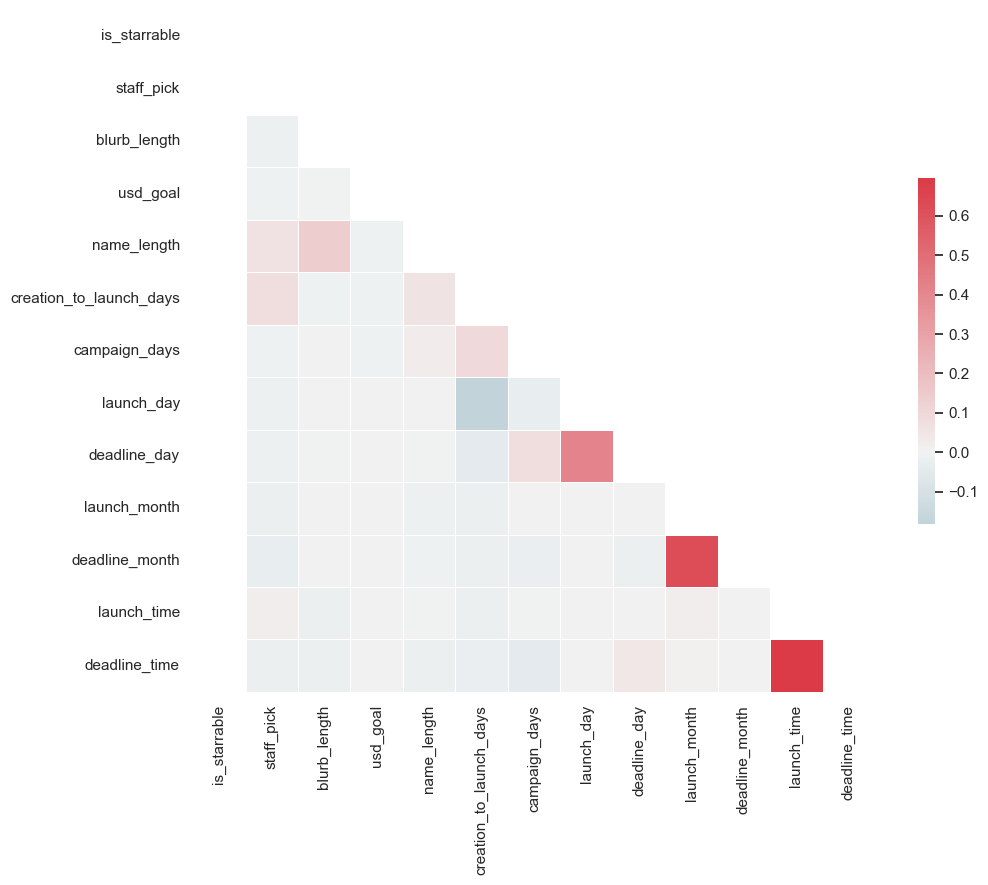

In [50]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});


> The dependent variable will now be converted into 1s (successful) and 0s (failure):

In [51]:
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})

In [52]:
df.dtypes

category                    object
country                     object
is_starrable                  bool
staff_pick                    bool
state                        int64
blurb_length                 int64
usd_goal                   float64
name_length                  int64
creation_to_launch_days      int64
campaign_days                int64
launch_day                   int64
deadline_day                 int64
launch_month                 int64
deadline_month               int64
launch_time                  int64
deadline_time                int64
dtype: object

In [53]:
df['staff_pick'] = df['staff_pick'].astype(str)
df['is_starrable'] = df['is_starrable'].astype(str)


In [54]:
df.head(5)

,category,country,is_starrable,staff_pick,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
0,games,US,False,False,1,22,1000.00,4,8,1,10,9,0,0,19,19
1,music,US,False,False,1,15,15000.00,7,17,1,13,12,3,3,7,7
2,games,GB,False,False,0,23,12160.66,8,5,1,12,13,22,22,19,18
3,publishing,US,False,False,1,24,2800.00,7,4,1,10,9,32,32,21,21
4,music,US,False,False,1,18,3500.00,4,22,0,2,2,25,25,4,4


In [55]:
# Creating list for categorical predictors/features 

cat_features = list(df.columns[df.dtypes==object])
cat_features

['category', 'country', 'is_starrable', 'staff_pick']

In [56]:
# Creating list for numerical predictors/features
# Since 'state' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(df.columns[df.dtypes!=object])
num_features.remove('state')
num_features


['blurb_length',
 'usd_goal',
 'name_length',
 'creation_to_launch_days',
 'campaign_days',
 'launch_day',
 'deadline_day',
 'launch_month',
 'deadline_month',
 'launch_time',
 'deadline_time']

---
## <span style="color:navy">__Train-Test-Split__

Let's split the data set into a training and test set. Using the training set and cross validation we will train our model and find the best hyperparameter combination. In the end the test set will be used for the final evaluation of our best model.

In [57]:
# Define predictors and target variable
X = df.drop('state', axis=1)
y = df['state']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 192664 observations in our dataset and 15 features
Our target vector has also 192664 values


In [58]:
# Split into train and test set 
RSEED =42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED, stratify=y)

In [59]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (144498, 15)
X_test shape: (48166, 15)
y_train shape: (144498,)
y_test shape: (48166,)


---
## <span style="color:navy">__Baseline Model__

In [60]:
#simple model by campaign_days:
# df_pclass = pd.DataFrame(df['usd_goal'])
df_pclass = pd.DataFrame(X_test['usd_goal'])

base_model_pred = df_pclass.applymap(lambda x: 0 if x >= 4000   else 1)

base_model_pred

,usd_goal
141673,1
73410,0
91050,1
177006,0
91743,1
...,...
46000,1
25379,1
66211,1
158619,0


In [61]:
f1_basemodel = f1_score(y_test, base_model_pred)

In [62]:
f1_basemodel

0.6040598248932394

In [63]:
accuracy_base = accuracy_score(y_test, base_model_pred)
recall_base = recall_score(y_test, base_model_pred)
precision_base = precision_score(y_test, base_model_pred)
f1_base = f1_score(y_test, base_model_pred)

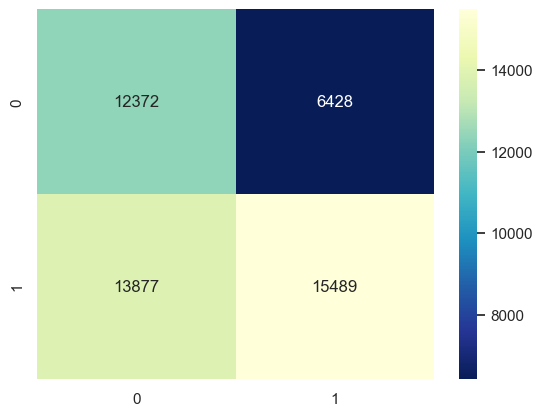

In [64]:
cm = confusion_matrix(y_test, base_model_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

---
## <span style="color:navy">__Preprocessing Pipeline__


Building a Pipeline always follows the same syntax. In our case we create one pipeline for our numerical features and one for our categorical features.

The missing values of the numerical features should be filled with the median value of the features and in the end, each feature should be scaled using the StandardScaler.

The missing values of the categorical features should be changed to "missing". In the end, we encode all categorical features as a one-hot numeric array.

In the end both pipelines are combined into one pipeline called "preprocessor" using ColumnTransformer from scikit-learn.

In [65]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

import pip
pip.main(['install', 'xgboost'])
import xgboost as xgb
from xgboost import XGBClassifier

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: xgboost in ./.venv/lib/python3.9/site-packages (1.7.3)

Requirement already satisfied: numpy in ./.venv/lib/python3.9/site-packages (from xgboost) (1.22.0)

Requirement already satisfied: scipy in ./.venv/lib/python3.9/site-packages (from xgboost) (1.9.3)

In [66]:
# Pipeline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)

num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [67]:
#from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

---
## <span style="color:navy">__Predictive Modelling using Pipelines__

Now that we have a preprocessing pipeline we can add a model on top (this sequence will also be handled by a Pipeline) and see how it performs using cross validation.
In [ ]:


### <span style="color:blue">__1. Logistic Regression__

In [68]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])


### <span style="color:blue">__2. Random Forest__

In [69]:
# Random Forests with default settings
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
                    ('pipe_rf', RandomForestClassifier())])
pipe_rf.fit(X_train, y_train)
print("Score:", round(pipe_rf.score(X_test, y_test),5))

Score: 0.77696



### <span style="color:blue">__3. XGBoost__

In [70]:
# XGBoost with default settings
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
                    ('pipe_xgb', xgb.XGBClassifier())])
pipe_xgb.fit(X_train, y_train)
print("Score:", round(pipe_xgb.score(X_test, y_test),5))

Score: 0.75584



### <span style="color:black">__> Predictions:__

In [71]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted_logreg = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)
y_train_predicted_rf = cross_val_predict(pipe_rf, X_train, y_train, cv=5)
y_train_predicted_xgb = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)



### <span style="color:black">__> Performance and Validation of the Models:__


In [77]:
accuracy_logreg = accuracy_score(y_train, y_train_predicted_logreg)
recall_logreg = recall_score(y_train, y_train_predicted_logreg)
precision_logreg = precision_score(y_train, y_train_predicted_logreg)
f1_logreg = f1_score(y_train, y_train_predicted_logreg)

accuracy_rf = accuracy_score(y_train, y_train_predicted_rf)
recall_rf = recall_score(y_train, y_train_predicted_rf)
precision_rf = precision_score(y_train, y_train_predicted_rf)
f1_rf = f1_score(y_train, y_train_predicted_rf)

accuracy_xgb = accuracy_score(y_train, y_train_predicted_xgb)
recall_xgb = recall_score(y_train, y_train_predicted_xgb)
precision_xgb = precision_score(y_train, y_train_predicted_xgb)
f1_xgb = f1_score(y_train, y_train_predicted_xgb)


In [78]:
validation_scores = pd.DataFrame([['model','accuracy','recall','precision','f1'],['logreg',accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],['random_forest',accuracy_rf,recall_rf,precision_rf ,f1_rf],['xgboost',accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]])

In [79]:
validation_scores

,0,1,2,3,4
0,model,accuracy,recall,precision,f1
1,logreg,0.718259,0.856775,0.728764,0.787602
2,random_forest,0.770834,0.877229,0.776082,0.823561
3,xgboost,0.756094,0.858625,0.768482,0.811057


---
## <span style="color:navy">__Optimizing via Grid Search__
In order to optimize our model we will use gird search. At first we have to define a parameter space we want to search for the best parameter combination. Then we have to initiate our grid search via GridSearchCV. The last step is to use the fit method providing our training data as input.

In [80]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='f1', 
                           verbose=5, n_jobs=-1)

In [81]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.7s
[CV 3/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.7s
[CV 2/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.7s
[CV 1/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.768 total time=   0.9s
[CV 4/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.770 total time=   1.0s
[CV 3/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.769 total time=   1.1s
[CV 2/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.769 total time=   1.1s
[CV 5/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=liblinear;, score=0.765 total time=   1.2s
[CV 5/5] END logreg__C=0.001, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total tim

/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.4min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.4min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.772 total time= 1.4min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.776 total time= 1.5min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=0.001, logreg__penalty=l2, logreg__solver=sag;, score=0.773 total time= 1.5min
[CV 2/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.790 total time=   6.8s
[CV 3/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.787 total time=   9.3s
[CV 4/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.791 total time=   8.2s
[CV 1/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.4s
[CV 2/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.4s
[CV 3/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.6s
[CV 4/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.6s
[CV 5/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=lbfgs;, score=nan total time=   0.5s
[CV 1/5] END logreg__C=1, logreg__penalty=l1, logreg__solver=liblinear;, score=0.789 total time=

/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.787 total time= 1.5min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.788 total time= 1.5min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.789 total time= 1.5min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=sag;, score=0.785 total time= 1.5min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.787 total time= 1.3min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.789 total time= 1.3min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.786 total time= 1.2min


/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/karine_real/Neue_Fische/ml_project_kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.786 total time=  53.7s
[CV 4/5] END logreg__C=10, logreg__penalty=l2, logreg__solver=sag;, score=0.790 total time=  54.4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['blurb_length',
                                                                          'usd_goal',
                                                                          'name_length',
                                                                          'creation_to_launch_days',
                                  

In [82]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.79
Best parameters:
{'logreg__C': 10, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [83]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model = grid_logreg.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['blurb_length', 'usd_goal',
                                                   'name_length',
                                                   'creation_to_launch_days',
                                                   'campaign_days',
                                                   'launch_day', 'deadline_day',
                                                   'launch_month',
                                                   'deadline_month',
                                                 

---
## <span style="color:navy">__Evaluation after Grid Search__

Finally we have a good model. Let's see if it also passes the final evaluation on the test data. Therefore we have to prepare the test set in the same way we did with the training data. Thanks to our pipeline it's done in a blink and we can be sure no data-leakage happened at any step through the whole data preprocessing.

When we saved the best model in the cell above, we did not only save the trained model but also the fitted preprocessing pipeline. Thus, transforming the test data the same way as the train data happens also when calling the .predict method on the best_model.

In [84]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))
print("f1: {:.2f}".format(f1_score(y_test, y_test_predicted)))

Accuracy: 0.72
Recall: 0.86
Precision: 0.73
f1: 0.79


In [85]:
y_train_predicted = best_model.predict(X_train)

accuracy_cvgridsearch = accuracy_score(y_train, y_train_predicted)
recall_cvgridsearch = recall_score(y_train, y_train_predicted)
precision_cvgridsearch = precision_score(y_train, y_train_predicted)
f1_cvgridsearch = f1_score(y_train, y_train_predicted)

In [86]:
validation_scores_X_train = pd.DataFrame([
                                  [accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],
                                  [accuracy_cvgridsearch, recall_cvgridsearch,precision_cvgridsearch,f1_cvgridsearch],
                                  [accuracy_rf,recall_rf,precision_rf ,f1_rf],
                                  [accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_train.index = ['logreg','gridsearchCV_logreg','random_forest','xgboost']
validation_scores_X_train

,accuracy,recall,precision,f1
logreg,0.718259,0.856775,0.728764,0.787602
gridsearchCV_logreg,0.719782,0.858545,0.729622,0.788851
random_forest,0.770834,0.877229,0.776082,0.823561
xgboost,0.756094,0.858625,0.768482,0.811057


In [87]:
y_test_predicted = best_model.predict(X_test)
y_test_predicted_logreg = cross_val_predict(pipe_logreg, X_test, y_test, cv=5)
y_test_predicted_rf = cross_val_predict(pipe_rf, X_test, y_test, cv=5)
y_test_predicted_xgb = cross_val_predict(pipe_xgb, X_test, y_test, cv=5)


### <span style="color:black">__> Performance of the models:__

In [88]:
accuracy_logreg = accuracy_score(y_test, y_test_predicted_logreg)
recall_logreg = recall_score(y_test, y_test_predicted_logreg)
precision_logreg = precision_score(y_test, y_test_predicted_logreg)
f1_logreg = f1_score(y_test, y_test_predicted_logreg)

accuracy_rf = accuracy_score(y_test, y_test_predicted_rf)
recall_rf = recall_score(y_test, y_test_predicted_rf)
precision_rf = precision_score(y_test, y_test_predicted_rf)
f1_rf = f1_score(y_test, y_test_predicted_rf)

accuracy_xgb = accuracy_score(y_test, y_test_predicted_xgb)
recall_xgb = recall_score(y_test, y_test_predicted_xgb)
precision_xgb = precision_score(y_test, y_test_predicted_xgb)
f1_xgb = f1_score(y_test, y_test_predicted_xgb)

accuracy_cvgridsearch = accuracy_score(y_test, y_test_predicted)
recall_cvgridsearch = recall_score(y_test, y_test_predicted)
precision_cvgridsearch = precision_score(y_test, y_test_predicted)
f1_cvgridsearch = f1_score(y_test, y_test_predicted)

In [94]:
validation_scores_X_train = pd.DataFrame([
                                  [accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],
                                  [accuracy_cvgridsearch, recall_cvgridsearch,precision_cvgridsearch,f1_cvgridsearch],
                                  [accuracy_rf,recall_rf,precision_rf ,f1_rf],
                                  [accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_train.index = ['logreg','gridsearchCV_logreg','random_forest','xgboost']
validation_scores_X_train

,accuracy,recall,precision,f1
logreg,0.717581,0.856569,0.728152,0.787157
gridsearchCV_logreg,0.720259,0.860894,0.729190,0.789587
random_forest,0.750467,0.858918,0.762047,0.807588
xgboost,0.746066,0.843969,0.764160,0.802084



### <span style="color:black">__> Confusion Matrices:__

> Logistic Regression:

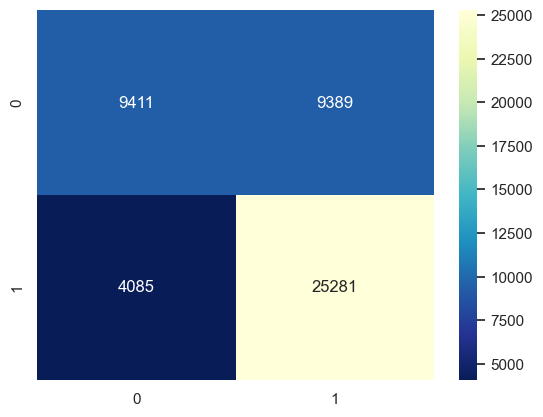

In [95]:
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

> XGBoost:

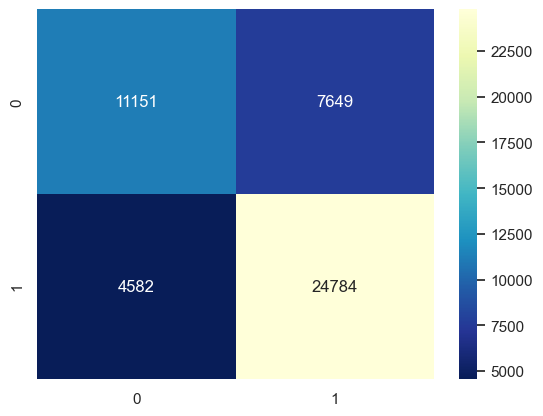

In [96]:
cm = confusion_matrix(y_test, y_test_predicted_xgb)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

> Random Forest:

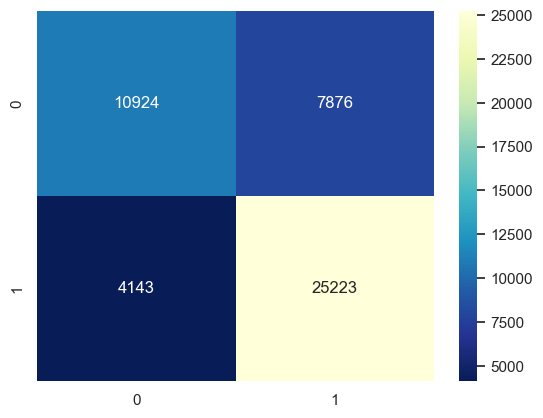

In [97]:
cm = confusion_matrix(y_test, y_test_predicted_rf)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

---
## <span style="color:navy">__Final Performance Metrics Comparison__

In [98]:
validation_scores_X_test = pd.DataFrame([
                                  [accuracy_base, recall_base,precision_base,f1_base],
                                  [accuracy_logreg, recall_logreg,precision_logreg,f1_logreg],
                                  [accuracy_cvgridsearch, recall_cvgridsearch,precision_cvgridsearch,f1_cvgridsearch],
                                  [accuracy_rf,recall_rf,precision_rf ,f1_rf],
                                  [accuracy_xgb,recall_xgb,precision_xgb ,f1_xgb]],
                                        columns= ['accuracy','recall','precision','f1']
                                        )
validation_scores_X_test.index = ['base model','logreg','gridsearchCV_logreg','random_forest','xgboost']
validation_scores_X_test

,accuracy,recall,precision,f1
base model,0.578437,0.527447,0.706712,0.604060
logreg,0.717581,0.856569,0.728152,0.787157
gridsearchCV_logreg,0.720259,0.860894,0.729190,0.789587
random_forest,0.750467,0.858918,0.762047,0.807588
xgboost,0.746066,0.843969,0.764160,0.802084
